In [1]:
suppressPackageStartupMessages(library(dplyr)) 
library(ggplot2)
library(pheatmap)
library(RColorBrewer)
library(Seurat)
library(harmony)
library(repr)
suppressPackageStartupMessages(library(GenomicRanges))

source("/projects/ps-renlab2/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")

Warning message:
“package ‘pheatmap’ was built under R version 4.3.2”
Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: Rcpp

Warning message:
“package ‘dichromat’ was built under R version 4.3.2”

Attaching package: ‘Matrix’


The following object is masked from ‘package:S4Vectors’:

    expand


Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal




In [2]:
### set cell tree
corder <- c('vCM','aCM','Epicardial','SM','Pericyte','Neuronal','Fibroblast',
            'Adipocyte','Endothelial','Endocardial','Myeloid','Lymphoid')

In [3]:
celltype_colors <- c(
    vCM = "#b94656",
    aCM = "#b95c38",
    Fibroblast = "#c0a13b",
    SM = "#71893b",
    Pericyte = "#6dbc5f",
    Epicardial = "#45c097",
    Endocardial = "#628ed6",
    Endothelial = "#6a70d7",
    Neuronal = "#5a3687",
    Myeloid = "#c074cc",
    Lymphoid = "#d16bad",
    Adipocyte = "#aa3d71"
)

cols1 <- c('#1F78B4', '#FB9A99'); names(cols1) <- c("M", "F")
cols2 <- c('#B2DF8A', '#FF7F00', '#CAB2D6'); names(cols2) <- c("CONTROL", "Ischemic", "Non-ischemic")
cols3 <- c('#B15928', '#FDBF6F'); names(cols3) <- c("TRUE", "FALSE")
cols4 <- c("#006934", "#2EA7E0", "#956134", "#036EB8"); names(cols4) <- c("Hi-C", "H3K27ac", "H3K27me3","ATAC")
cols5 <- c("#4f652f", "#d44f3a", "#5bac96", "#e6b8b3"); names(cols5) <- c("LV", "LA", "RV","RA")
cols <- c("#cd5c5c", "#c0c0c0", "#008000", "#ffc800", '#66cdaa')
names(cols) <- c("E1", "E2", "E3", "E4", "E5")

cols0 <- c('3\' UTR ' = "#6F4066",
           '5\' UTR ' = "#B78EA6",
           'CpG' = "#71818D",
           'Intergenic' = "#326680",
           'TTS ' = "#B0BEC5",
           'exon ' = "#527172",
           'intron ' = "#495347",
           'non-coding ' = "#73A085",
           'promoter-TSS ' = "#D0C185",
           'LINE' = "#ECBF6D",
           'LTR' = "#C56D48",
           'Other repeats' = "#C0A08D",
           'SINE' = "#B05857",
           'Simple_repeat' = "#701B28")

In [4]:
options(future.globals.maxSize = 16 * 1024^3)

In [5]:
hg38 <- read.table("/projects/ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/Paired-Tag/hg38/hg38.gcode.10X.bed")
head(hg38)

bgene <- hg38 %>% filter(V1 %in% c("chrX", "chrY", "chrM")) %>% select(V6) %>% unlist %>% unique

,V1,V2,V3,V4,V5,V6
,<chr>,<int>,<int>,<chr>,<chr>,<chr>
1,chr1,29554,31109,+,ENSG00000243485,MIR1302-2HG
2,chr1,34554,36081,-,ENSG00000237613,FAM138A
3,chr1,65419,71585,+,ENSG00000186092,OR4F5
4,chr1,89295,133723,-,ENSG00000238009,AL627309.1
5,chr1,89551,91105,-,ENSG00000239945,AL627309.3
6,chr1,139790,140339,-,ENSG00000239906,AL627309.2


In [ ]:
abc <- read.table("../../87.FNIH_DHC_IGM_240925/05.R/abc/FNIH_heart_celltype_abc_links.txt", 
                  sep = "\t", header = T)

## Load RNA integrated objects

In [54]:
obj <- qs::qread("integration/CAREHF_Multiome_DPT_RNA_int.obj.qs")
obj

An object of class Seurat 
73992 features across 713384 samples within 3 assays 
Active assay: integrated (3000 features, 3000 variable features)
 2 layers present: data, scale.data
 2 other assays present: RNA, SCT
 2 dimensional reductions calculated: pca, umap

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


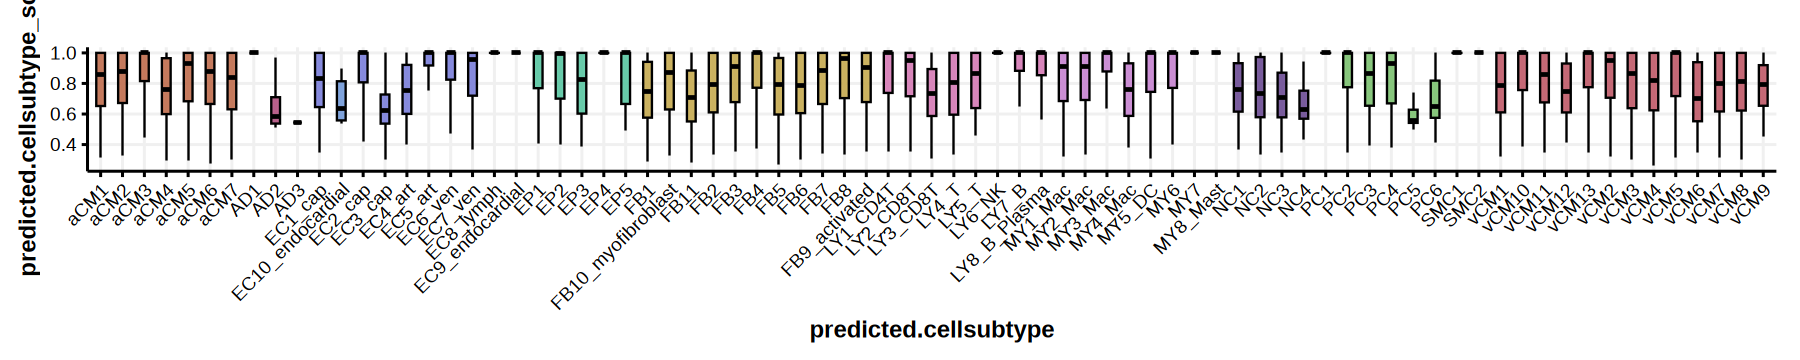

In [39]:
### Subtype check?
options(repr.plot.width = 15, repr.plot.height = 3)

obj@meta.data[obj$orig.ident == "DPT",] %>%
mutate(predicted.celltype = gsub("label_", "", predicted.celltype)) %>%
ggplot(aes(x = predicted.cellsubtype, y = predicted.cellsubtype_scores, fill = predicted.celltype)) +
geom_boxplot(width = 0.4, color = "black", alpha=0.8, coef = 2, outlier.shape = NA) + 
theme_Publication() + NoLegend() + scale_fill_manual(values = celltype_colors) + 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

## Calculate subtype cpm

In [197]:
ac <- anndata::read_h5ad("FNIH_Heart_signal/FNIH_Heart_pool.H3K27ac.HeartUnionPeak.h5ad")
tmeta <- obj@meta.data[obj$orig.ident == "DPT" & obj$Target == "H3K27ac",]
rownames(tmeta) <- paste0(tmeta$dna, ":", tmeta$dna_bc)
ac$obs$predicted.id <- tmeta[ac$obs_names,]$predicted.cellsubtype %>% as.character
ac$obs$nCount_histone <- ac$obs$n_fragment %>% as.character %>% as.integer

valid <- tmeta %>% filter(integrated_subtype == 1) %>% rownames
valid <- intersect(valid, ac$obs_names)
accpm <- ArcXPM(t(ac$X)[,valid], meta = ac$obs[valid,], 
                group.by = "predicted.id", method = "CPM")

sparsity: 0.402979504885036
coarse dgTMatrix into Matrix.
check readSums:  75 
check obj_mtx_collapse:  75 


In [198]:
me <- anndata::read_h5ad("FNIH_Heart_signal/FNIH_Heart_pool.H3K27me3.HeartUnionPeak.h5ad")
tmeta <- obj@meta.data[obj$orig.ident == "DPT" & obj$Target == "H3K27me3",]
rownames(tmeta) <- paste0(tmeta$dna, ":", tmeta$dna_bc)
me$obs$predicted.id <- tmeta[me$obs_names,]$predicted.cellsubtype %>% as.character
me$obs$nCount_histone <- me$obs$n_fragment %>% as.character %>% as.integer

valid <- tmeta %>% filter(integrated_subtype == 1) %>% rownames
valid <- intersect(valid, me$obs_names)
mecpm <- ArcXPM(t(me$X)[,valid], meta = me$obs[valid,], 
                group.by = "predicted.id", method = "CPM")

sparsity: 0.384710273443102
coarse dgTMatrix into Matrix.
check readSums:  75 
check obj_mtx_collapse:  75 


In [449]:
# atac <- anndata::read_h5ad("../reference/ATAC_processed_peaks.h5ad")
tmeta <- atac$obs
tmeta$nCount_histone <- atac$obs$n_fragment %>% as.character %>% as.integer
ataccpm <- ArcXPM(t(atac$X), meta = tmeta, 
                  group.by = "cell.sub_types", method = "CPM")

### correct naming

sparsity: 0.869201703908025
coarse dgTMatrix into Matrix.
check readSums:  77 
check obj_mtx_collapse:  77 


In [465]:
colnames(ataccpm)

[1] "FB4_myo"          "EC2_cap"          "vCM7"             "EC7_ven"         
 [5] "FB2"              "MY1_Mac"          "EC4_art"          "PC1"             
 [9] "vCM6"             "MY2_Mac"          "EC1_cap"          "vCM4"            
[13] "vCM11"            "FB5"              "FB1"              "vCM1"            
[17] "vCM10"            "vCM2"             "MY8_Mast"         "EC9_endocardial" 
[21] "FB3"              "FB8_activated"    "vCM9"             "LY2_CD8T"        
[25] "PC4"              "EC6_ven"          "vCM5"             "SMC1"            
[29] "MY5_DC"           "vCM3"             "MY3_Mac"          "LY7_B"           
[33] "NC1"              "vCM8"             "LY1_CD4T"         "SMC2"            
[37] "LY6_NK"           "PC2"              "FB7"              "PC5"             
[41] "EC8_lymph"        "LY3_CD8T"         "LY8_B_Plasma"     "vCM12"           
[45] "PC3"              "NC2"              "MY6"              "MY4_Mac"         
[49] "EC3_cap"          "FB10"             "AD1"              "LY4_T"           
[53] "FB6"              "NC3"              "EC5_art"          "EP1"             
[57] "FB11"             "FB9"              "MY7"              "AD3"             
[61] "EP4"              "vCM13"            "PC6"              "EP3"             
[65] "EP2"              "EC10_endocardial" "AD2"              "NC4"             
[69] "LY5_T"            "EP5"              "aCM2"             "aCM1"            
[73] "aCM4"             "aCM5"             "aCM3"             "aCM6"            
[77] "aCM7"

In [457]:
smatch <- read.table("../reference/MULTIOME_subtype_rename.250324", header = T)
smatch[smatch$old == "FB4_myofibroblast",]$old <- "FB4_myo"
ncol(ataccpm)
ntr <- intersect(colnames(ataccpm), smatch$old)
ntr %>% length

[1] 77

[1] 41

In [463]:
nnn <- colnames(ataccpm) 
nnn[match(ntr, nnn)] <- smatch[match(nnn[match(ntr, nnn)], smatch$old), ]$new
intersect(nnn, smatch$old) %>% length
intersect(nnn, smatch$new) %>% length

[1] 37

[1] 41

In [464]:
colnames(ataccpm) <- nnn
colnames(ataccpm)

[1] "FB10_myofibroblast" "EC1_cap"            "vCM3"              
 [4] "EC7_ven"            "FB7"                "MY1_Mac"           
 [7] "EC5_art"            "PC1"                "vCM11"             
[10] "MY2_Mac"            "EC2_cap"            "vCM2"              
[13] "vCM6"               "FB2"                "FB8"               
[16] "vCM4"               "vCM12"              "vCM7"              
[19] "MY8_Mast"           "EC9_endocardial"    "FB3"               
[22] "FB9_activated"      "vCM5"               "LY2_CD8T"          
[25] "PC4"                "EC6_ven"            "vCM8"              
[28] "SMC1"               "MY5_DC"             "vCM1"              
[31] "MY3_Mac"            "LY7_B"              "NC1"               
[34] "vCM13"              "LY1_CD4T"           "SMC2"              
[37] "LY6_NK"             "PC2"                "FB4"               
[40] "PC5"                "EC8_lymph"          "LY3_CD8T"          
[43] "LY8_B_Plasma"       "vCM10"              "PC3"               
[46] "NC2"                "MY6"                "MY4_Mac"           
[49] "EC3_cap"            "FB11"               "AD1"               
[52] "LY4_T"              "FB1"                "NC3"               
[55] "EC4_art"            "EP1"                "FB6"               
[58] "FB5"                "MY7"                "AD3"               
[61] "EP4"                "vCM9"               "PC6"               
[64] "EP3"                "EP2"                "EC10_endocardial"  
[67] "AD2"                "NC4"                "LY5_T"             
[70] "EP5"                "aCM5"               "aCM2"              
[73] "aCM4"               "aCM3"               "aCM1"              
[76] "aCM6"               "aCM7"

In [199]:
write.table(ataccpm, "FNIH_Heart_signal/FNIH_Heart_pool.ATAC.HeartUnionPeak.subtype.cpm.txt", sep = "\t", quote = F, row.names = T, col.names = T)
write.table(accpm, "FNIH_Heart_signal/FNIH_Heart_pool.H3K27ac.HeartUnionPeak.subtype.cpm.txt", sep = "\t", quote = F, row.names = T, col.names = T)
write.table(mecpm, "FNIH_Heart_signal/FNIH_Heart_pool.H3K27me3.HeartUnionPeak.subtype.cpm.txt", sep = "\t", quote = F, row.names = T, col.names = T)

In [55]:
mmg <- subset(obj, cells = rownames(obj@meta.data[obj$integrated_subtype == "1",]))

mmg[["RNA"]]$data.2 <- NULL
mmg[["RNA"]] <- as(mmg[["RNA"]], "Assay")
rpkm <- ArcXPM2(mmg[["RNA"]]@counts, meta = mmg@meta.data, method = "RPKM", 
                group.by = "nn2.cell_subtype", 
                gene_length = "/projects/ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/Paired-Tag/hg38/hg38.gcode.10X.bed")
write.table(rpkm, "integration/FNIH_Heart_pool.int.subtype.rpkm.txt", sep = "\t", quote = F, row.names = T, col.names = T)

Warning message:
“Joining 'counts' layers. If you have the same cells in multiple layers, the expression value for the cell in the 'counts' slot will be the value from the 'counts.1' layer.”
Warning message:
“No layers found matching search pattern provided”
Warning message:
“No layers found matching search pattern provided”
Warning message:
“No layers found matching search pattern provided”
Warning message:
“Layer ‘data’ is empty”
Warning message:
“No layers found matching search pattern provided”
Warning message:
“No layers found matching search pattern provided”
Warning message:
“Layer ‘scale.data’ is empty”
Warning message:
“Assay RNA changing from Assay5 to Assay”


sparsity: 0.272852881388167
check readSums:  77 
check obj_mtx_collapse:  77 


In [ ]:
### sanity check: plot with NPPA to see whether the cell lables are correct

In [20]:
rpkm <- read.table("integration/FNIH_Heart_pool.int.subtype.rpkm.txt", sep = "\t", header = T, row.names = 1)
ataccpm <- read.table("FNIH_Heart_signal/FNIH_Heart_pool.ATAC.HeartUnionPeak.subtype.cpm.txt", sep = "\t", row.names = 1, header = T)
accpm <- read.table("FNIH_Heart_signal/FNIH_Heart_pool.H3K27ac.HeartUnionPeak.subtype.cpm.txt", sep = "\t", row.names = 1, header = T)
mecpm <- read.table("FNIH_Heart_signal/FNIH_Heart_pool.H3K27me3.HeartUnionPeak.subtype.cpm.txt", sep = "\t", row.names = 1, header = T)

In [7]:
rpkm[c("NPPA", "NPPB"), grep("vCM", colnames(rpkm))] %>%
as.data.frame 

,vCM4,vCM2,vCM3,vCM8,vCM1,vCM7,vCM5,vCM13,vCM12,vCM11,vCM6,vCM10,vCM9
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NPPA,1.965867,0.4481155,4.892103,23.81193,0.8169299,5.015424,4.416856,100.4704,29.55043,28.35458,5.151359,18.47602,2.19397
NPPB,2.300335,0.5040333,1.514987,22.36753,0.8069101,1.974095,1.458175,895.8804,46.23300,80.04415,8.489623,87.52600,17.18200


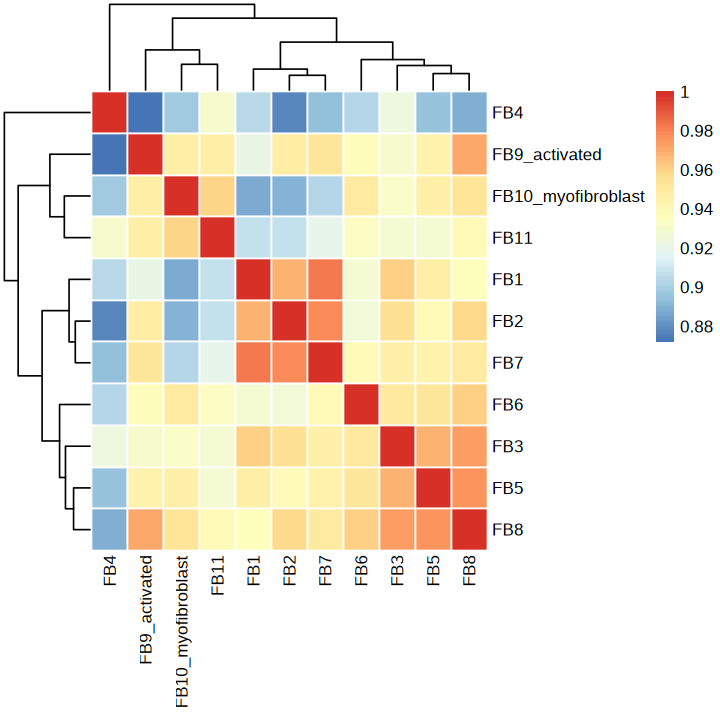

In [135]:
### Fibroblast
### read marker genes
qgene <- list()
for (file in list.files("../reference/subtype/", pattern = "FB.*_DESeq.xls")){
    fname <- gsub("_DESeq.xls", "", file)
    qgene[[fname]] <- read.table(paste0("../reference/subtype/", file), sep = "\t", row.names = 1, header = T) %>% 
    mutate(celltype = fname) %>%
    filter(padj < 0.01)
}
qgene <- do.call(rbind, qgene)

qqgene <- intersect(rownames(rpkm), unique(qgene[,1]))
qqgene <- setdiff(qqgene, bgene)

options(repr.plot.width = 6, repr.plot.height = 6)
rpkm[qqgene, stringr::str_sort(grep("FB", colnames(rpkm), value = T), numeric = T)] %>%
cor(method = "spearman", use = "complete.obs") %>%
pheatmap(cluster_rows = T, cluster_cols = T, 
         angle_col = 90, border_color = "white")

### FB4 doesn't look like an intemediate cluster?

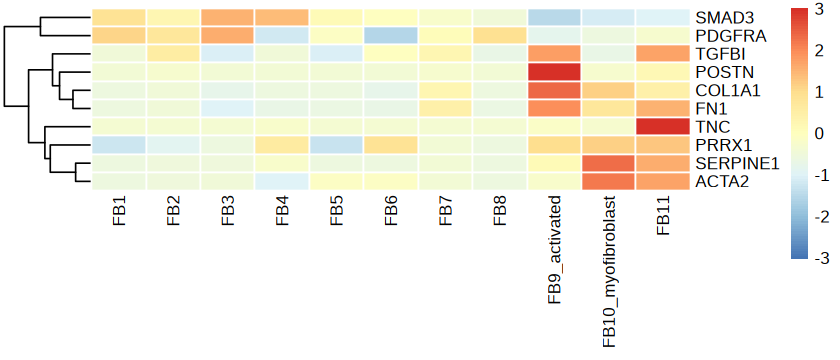

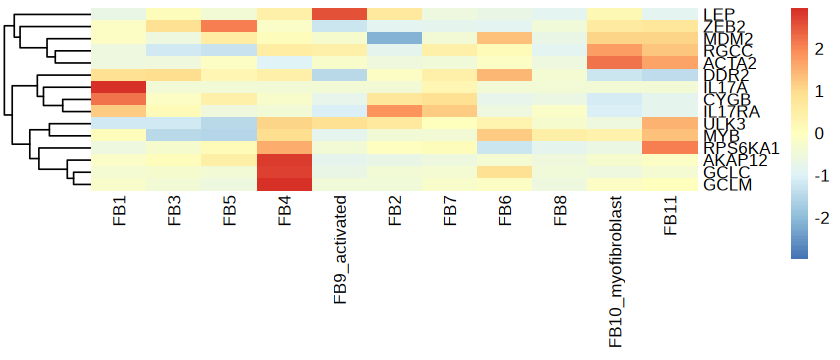

In [120]:
### Check fibrosis marker for fib?
qmarker <- c("SMAD3", "PRRX1", "SERPINE1", "PDGFRA", "POSTN", "ACTA2", "COL1A1", "FN1", "TNC", "TGFBI")
m24593 <- c('CYGB','IL17RA','ULK3','GCLC','GCLM','RGCC','IL17A','LEP','MDM2','MYB','DDR2','ACTA2','RPS6KA1','AKAP12','ZEB2')
options(repr.plot.width = 7, repr.plot.height = 3)

rpkm[qmarker, stringr::str_sort(grep("FB", colnames(rpkm), value = T), numeric = T)] %>%
pheatmap(scale = "row", cluster_cols = F, angle_col = 90, border_color = "white")

rpkm[m24593, stringr::str_sort(grep("FB", colnames(rpkm), value = T), numeric = T)] %>%
pheatmap(scale = "row", cluster_cols = T, treeheight_col = 0, angle_col = 90, border_color = NA)

In [372]:
### Cell number check
mmg@meta.data %>% filter(nn2.celltype == "Fibroblast", orig.ident == "MULTIOME") %>%
select(nn2.cell_subtype) %>% table

nn2.cell_subtype
               FB1 FB10_myofibroblast               FB11                FB2 
              3423               6532               1460               4419 
               FB3                FB4                FB5                FB6 
              9080               2861               1997               1364 
               FB7                FB8      FB9_activated 
             13978              19311               2732 

In [177]:
### split fib subtypes for chromhmm
### late: fb9-11
### med: fb4-8
### early: fb1-3
# table(mmg$nn2.cell_subtype, mmg$Target) %>%
# as.data.frame %>% filter()

tmp <- mmg@meta.data %>% 
filter(nn2.cell_subtype %in% grep("FB", colnames(rpkm), value = T), orig.ident %in% c("DPT", "MULTIOME")) %>%
filter(nn2.celltype != "Low quality") %>%
select(dna, dna_bc, orig.ident, nn2.cell_subtype, nn2.celltype, Target) %>%
mutate(bc = ifelse(orig.ident == "DPT", paste0(dna, ":", dna_bc), rownames(.))) %>%
mutate(Target = ifelse(orig.ident == "DPT", Target, "ATAC")) %>%
mutate(sample = paste0("FNIH_Heart_", nn2.celltype, "_", Target, ".bed")) %>%
mutate(cluster = paste0(nn2.cell_subtype, "_", Target))

qmeta <- tmp %>%
dplyr::select(cluster, bc, sample, orig.ident) %>%
setNames(c("cluster", "barcode", "sample", "library"))

write.table(qmeta, "chromhmm/cellsubtype/bed/fib_cluster.info.txt", 
            sep = "\t", quote = F, row.names = F, col.names = T)

qmeta2 <- tmp %>%
mutate(nn2.cell_subtype = ifelse(nn2.cell_subtype %in% paste0("FB", 1:3), "FB_early", nn2.cell_subtype)) %>%
mutate(nn2.cell_subtype = ifelse(nn2.cell_subtype %in% paste0("FB", 4:8), "FB_mid", nn2.cell_subtype)) %>%
mutate(nn2.cell_subtype = ifelse(nn2.cell_subtype %in% c("FB9_activated", "FB10_myofibroblast", "FB11"), "FB_late", nn2.cell_subtype)) %>%
mutate(cluster = paste0(nn2.cell_subtype, "_", Target)) %>%
dplyr::select(cluster, bc, sample, orig.ident) %>%
setNames(c("cluster", "barcode", "sample", "library"))

write.table(qmeta2, "chromhmm/cellsubtype/bed/fib_merged.info.txt", 
            sep = "\t", quote = F, row.names = F, col.names = T)

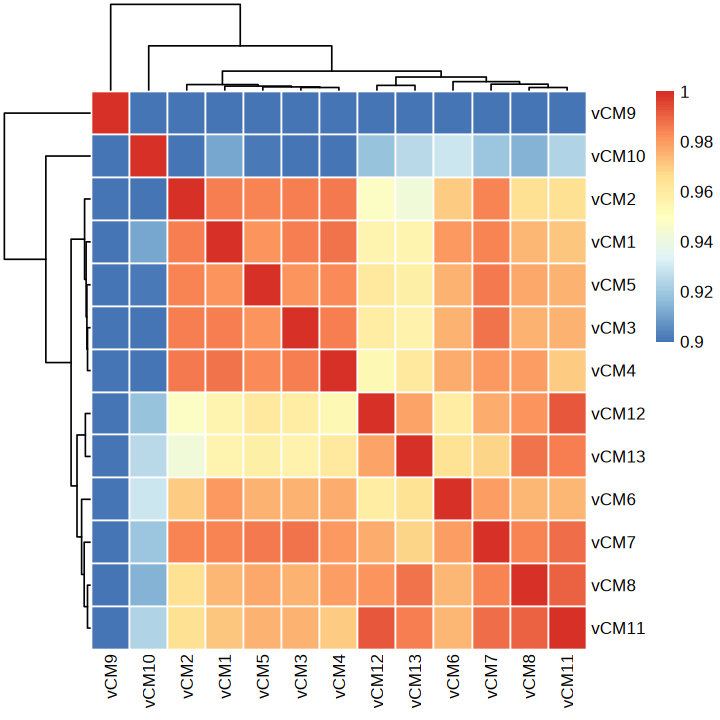

In [273]:
### vCM
### read vCM genes
qgene <- list()
for (file in list.files("../reference/subtype/", pattern = "vCM.*_DESeq.xls")){
    fname <- gsub("_DESeq.xls", "", file)
    qgene[[fname]] <- read.table(paste0("../reference/subtype/", file), sep = "\t", row.names = 1, header = T) %>% 
    mutate(celltype = fname) %>%
    filter(padj < 0.01)
}
qgene <- do.call(rbind, qgene)

qqgene <- intersect(rownames(rpkm), unique(qgene[,1]))
qqgene <- setdiff(qqgene, bgene)

options(repr.plot.width = 6, repr.plot.height = 6)
log10(rpkm[qqgene, stringr::str_sort(grep("vCM", colnames(rpkm), value = T), numeric = T)] + 1) %>%
cor(method = "pearson", use = "complete.obs") %>%
pheatmap(cluster_rows = T, cluster_cols = T, breaks = seq(0.9, 1, 0.001),
         angle_col = 90, border_color = "white")

### vCM9 doesn't look like an intemediate cluster?

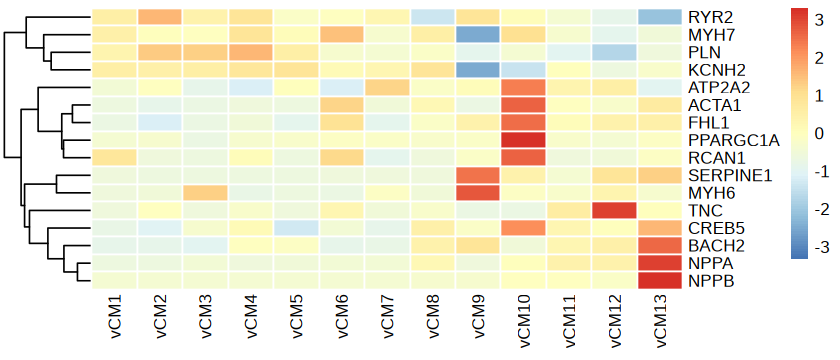

In [318]:
qmarker <- c("MYH6", "ATP2A2", "PLN", "RYR2", "KCNH2", "PPARGC1A", 
             "MYH7", "NPPA", "NPPB", "ACTA1", "CTGF", "CREB5", "BACH2",
             "RCAN1", "FHL1", "TNC", "SERPINE1")

options(repr.plot.width = 7, repr.plot.height = 3)
rpkm[intersect(rownames(rpkm), qmarker), stringr::str_sort(grep("vCM", colnames(rpkm), value = T), numeric = T)] %>%
pheatmap(scale = "row", cluster_cols = F, angle_col = 90, border_color = "white")

In [503]:
### Cell number check
mmg@meta.data %>% filter(nn2.celltype == "vCM", orig.ident == "MULTIOME") %>%
select(nn2.cell_subtype) %>% table

mmg@meta.data %>% filter(nn2.celltype == "vCM") %>%
select(nn2.cell_subtype) %>% table

nn2.cell_subtype
 vCM1 vCM10 vCM11 vCM12 vCM13  vCM2  vCM3  vCM4  vCM5  vCM6  vCM7  vCM8  vCM9 
 8889  1186  5999  2573  3941  8459  4269 10886  3433  2192  8945  7487   190 

nn2.cell_subtype
 vCM1 vCM10 vCM11 vCM12 vCM13  vCM2  vCM3  vCM4  vCM5  vCM6  vCM7  vCM8  vCM9 
12187  1852  8532  3494  6871 13819  5428 15605  5471  2594 12490 11355   207 

In [265]:
### split vCM subtypes for chromhmm
### late: vcm11-13
### med: vcm7-10
### early: vcm1-6

tmp <- mmg@meta.data %>% 
filter(nn2.cell_subtype %in% grep("vCM", colnames(rpkm), value = T), orig.ident %in% c("DPT", "MULTIOME")) %>%
filter(nn2.celltype != "Low quality") %>%
select(dna, dna_bc, orig.ident, nn2.cell_subtype, nn2.celltype, Target) %>%
mutate(bc = ifelse(orig.ident == "DPT", paste0(dna, ":", dna_bc), rownames(.))) %>%
mutate(Target = ifelse(orig.ident == "DPT", Target, "ATAC")) %>%
mutate(sample = paste0("FNIH_Heart_", nn2.celltype, "_", Target, ".bed")) %>%
mutate(cluster = paste0(nn2.cell_subtype, "_", Target))

qmeta <- tmp %>%
dplyr::select(cluster, bc, sample, orig.ident) %>%
setNames(c("cluster", "barcode", "sample", "library"))

write.table(qmeta, "chromhmm/cellsubtype/bed/vCM_cluster.info.txt", 
            sep = "\t", quote = F, row.names = F, col.names = T)

qmeta2 <- tmp %>%
mutate(nn2.cell_subtype = ifelse(nn2.cell_subtype %in% paste0("vCM", 1:6), "vCM_early", nn2.cell_subtype)) %>%
mutate(nn2.cell_subtype = ifelse(nn2.cell_subtype %in% paste0("vCM", 7:10), "vCM_mid", nn2.cell_subtype)) %>%
mutate(nn2.cell_subtype = ifelse(nn2.cell_subtype %in% paste0("vCM", 11:13), "vCM_late", nn2.cell_subtype)) %>%
mutate(cluster = paste0(nn2.cell_subtype, "_", Target)) %>%
dplyr::select(cluster, bc, sample, orig.ident) %>%
setNames(c("cluster", "barcode", "sample", "library"))

write.table(qmeta2, "chromhmm/cellsubtype/bed/vCM_merged.info.txt", 
            sep = "\t", quote = F, row.names = F, col.names = T)

## Check subtype chromatin states

In [274]:
sstate <- sstatesum <- list()
for (f in list.files("chromhmm/cellsubtype/output/")){
    fname <- gsub("_5_segments.bed", "", f)
    sstate[[fname]] <- read.table(paste0("chromhmm/cellsubtype/output/", f)) %>% mutate(group = fname)
    sstatesum[[fname]] <- sstate[[fname]] %>% 
    mutate(llen = V3 - V2) %>%
    group_by(V4) %>% summarise(Freq = sum(llen)) %>%
    ungroup %>% mutate(ratio = Freq/sum(Freq)) %>% mutate(group = fname)
}

### reference
for (fname in c("vCM", "Fibroblast")){
    sstate[[fname]] <- read.table(paste0("chromhmm/celltype/output/", fname, "_5_segments.bed")) %>% mutate(group = fname)
    sstatesum[[fname]] <- sstate[[fname]] %>% 
    mutate(llen = V3 - V2) %>%
    group_by(V4) %>% summarise(Freq = sum(llen)) %>%
    ungroup %>% mutate(ratio = Freq/sum(Freq)) %>% mutate(group = fname)
}

sstatesum <- do.call(rbind, sstatesum) 

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


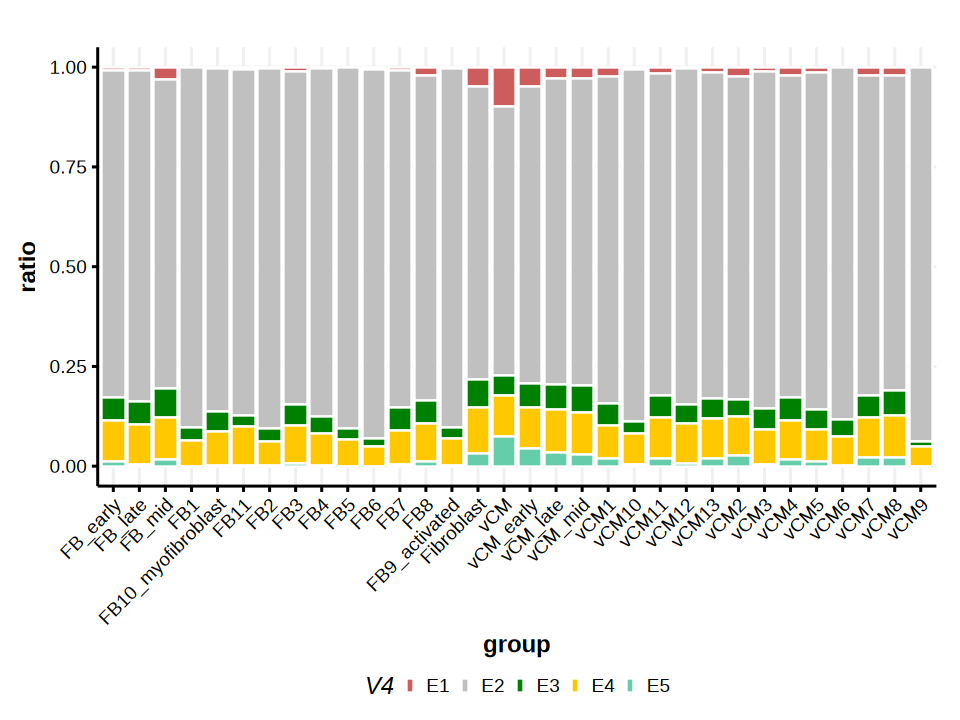

In [300]:
options(repr.plot.width = 8, repr.plot.height = 6)
sstatesum %>%
ggplot(aes(x = group, y = ratio, fill = V4)) + 
geom_col(position = "fill", color = "white") + 
theme_Publication() + 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
scale_fill_manual(values = cols)

In [636]:
### vCM
chmm <- list()
for (f in list.files("chromhmm/cellsubtype//annotate/", pattern = "^Heart_UnionPeak_FB.*")){
    fname = gsub("_annotate.bed", "", f)
    chmm[[f]] <- read.table(paste0("chromhmm/cellsubtype//annotate/", f)) %>% 
    mutate(range = paste0(V1, ":", V2, "-", V3)) %>%
    dplyr::select(c(range, V4)) %>% 
    group_by(range) %>%
    slice_sample(n = 1) %>%
    ungroup() %>%
    tibble::column_to_rownames("range") %>% setNames(fname)
}
commonf <- Reduce(intersect, lapply(chmm, rownames))
for (f in names(chmm)){
    chmm[[f]] <- chmm[[f]][commonf, , drop = F]
}
chmm <- Reduce(cbind, chmm[-1], chmm[[1]]) ### dont use do.call for cbind

In [637]:
colnames(chmm) <- gsub("Heart_UnionPeak_", "", colnames(chmm))
write.table(chmm, "chromhmm/cellsubtype/annotate/Fibroblast_subtype_chromhmm.xls", 
            sep = "\t", quote = F, row.names = T, col.names = T)

In [652]:
sstatesum <- chmm %>% tibble::rownames_to_column("bin") %>%
reshape2::melt(id.vars = "bin") %>%
dplyr::select(variable, value) %>%
table %>% as.data.frame %>%
group_by(variable) %>% mutate(ratio = Freq/sum(Freq)) %>%
ungroup

head(sstatesum)

variable,value,Freq,ratio
<fct>,<fct>,<int>,<dbl>
FB_early,E1,9481,0.033165077
FB_late,E1,9416,0.032937703
FB_mid,E1,22251,0.077835263
FB1,E1,1040,0.003637979
FB10_myofibroblast,E1,3224,0.011277735
FB11,E1,5963,0.020858913


Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


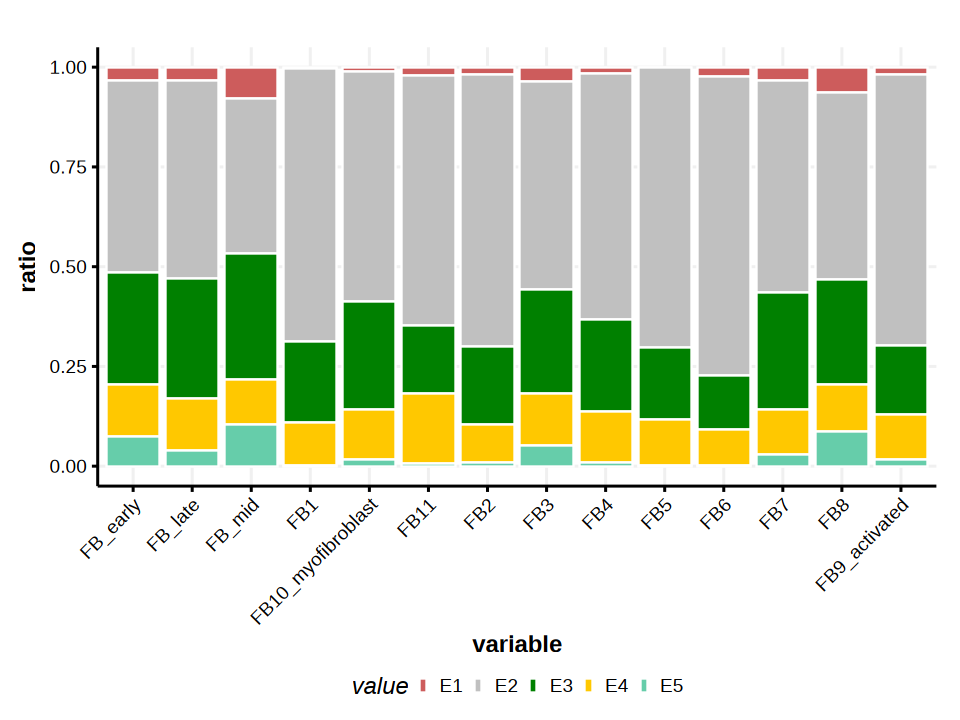

In [653]:
options(repr.plot.width = 8, repr.plot.height = 6)
sstatesum %>%
ggplot(aes(x = variable, y = ratio, fill = value)) + 
geom_col(position = "fill", color = "white") + 
theme_Publication() + 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
scale_fill_manual(values = cols)

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


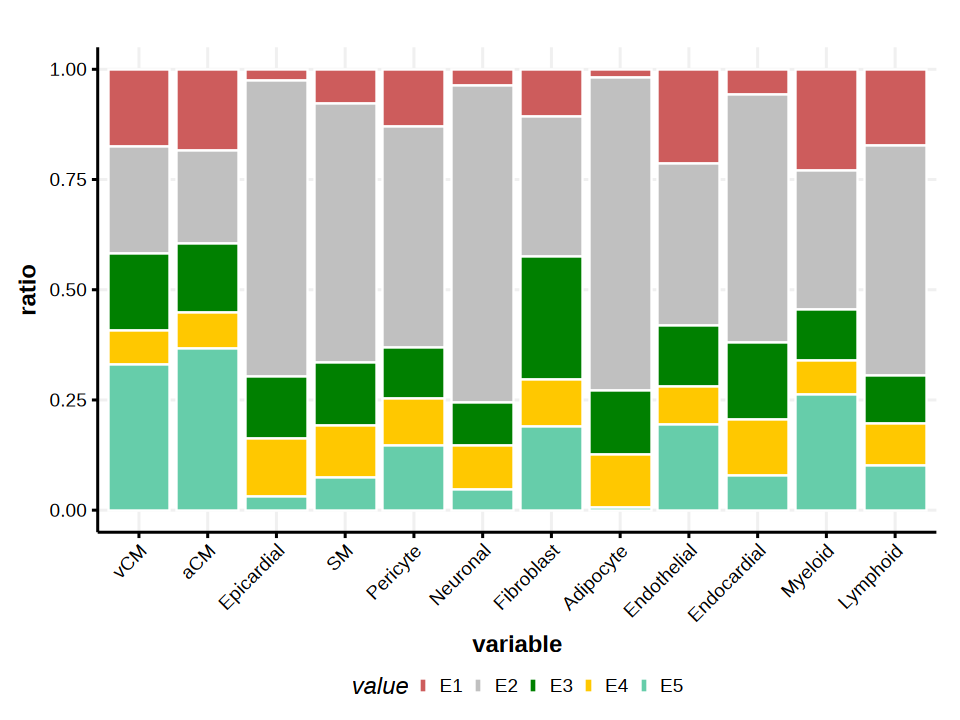

In [324]:
# chmm2 <- read.table("chromhmm/celltype/annotate//Heart_UnionPeak_by_celltype.xls")

options(repr.plot.width = 8, repr.plot.height = 6)
chmm2 %>% tibble::rownames_to_column("bin") %>%
reshape2::melt(id.vars = "bin") %>%
dplyr::select(variable, value) %>%
table %>% as.data.frame %>%
group_by(variable) %>% mutate(ratio = Freq/sum(Freq)) %>%
ungroup %>%
ggplot(aes(x = variable, y = ratio, fill = value)) + 
geom_col(position = "fill", color = "white") + 
theme_Publication() + 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
scale_fill_manual(values = cols)

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


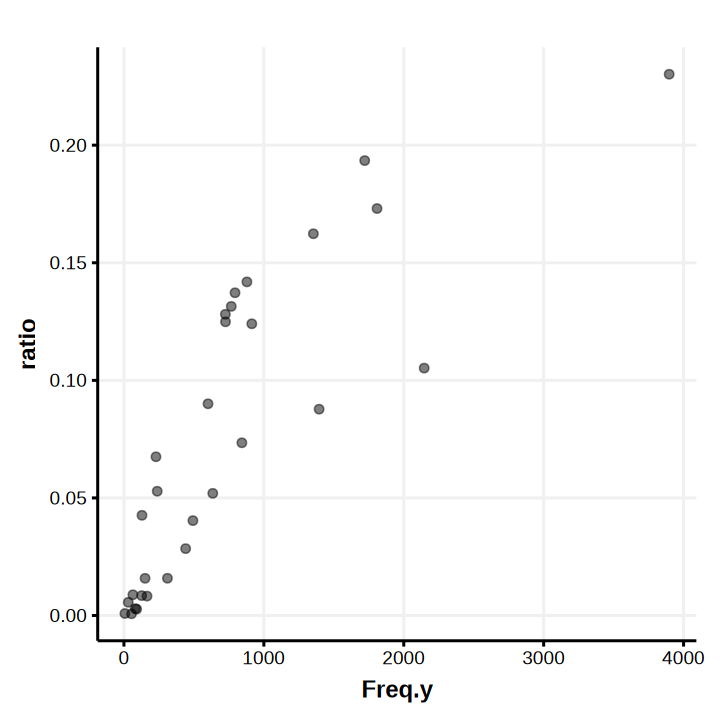

In [316]:
### Proportion of active state?
tmp <- list()
i = 1
for (f in list.files("chromhmm/cellsubtype/bed/", pattern = ".*info.txt")){
    tmp[[i]] <- read.table(paste0("chromhmm/cellsubtype/bed/", f), header = T)
    i = i + 1
}
tmp <- do.call(rbind, tmp) 
ccount <- tmp[grep("H3K27ac", tmp$cluster),] %>%
mutate(cluster = gsub("_H3K27ac", "", cluster)) %>%
select(cluster) %>% table %>% as.data.frame

options(repr.plot.width = 6, repr.plot.height = 6)
merge(sstatesum, ccount, by.x = "variable", by.y = "cluster") %>%
filter(value == "E5") %>%
ggplot(aes(x = Freq.y, y = ratio)) + 
geom_point(size = 2, alpha = 0.5) + 
theme_Publication()

In [12]:
### Use early-med-late classification for chromhmm!
ct <- "vCM"
elist <- read.csv(paste0("GRN/scenicplus/", ct, "/edges_R2G.csv")) %>% # filter(is_extended == "False") %>%
mutate(gene = stringr::str_split_fixed(Consensus_name, pattern = "_", n = 3)[,1])
rpeak <- read.table(paste0("../reference/FNIH_peaks/unified_peaks/", ct, "_UnifiedFiltVariable.bed")) %>%
mutate(range = paste0(V1, ":", V2, "-", V3))
elist <- elist %>% filter(Region %in% rpeak$range) ### retain peaks within that celltype

tforder <- read.table(paste0("GRN/subtype/", ct, "_GRN.order"))
table(tforder$V1 %in% unique(elist$gene))
table(tforder$V1 %in% bgene) ### How many on chrX/Y/M


TRUE 
  84 


FALSE  TRUE 
   81     3 

In [13]:
tforder <- tforder$V1 #setdiff(intersect(tforder$V1, unique(elist$gene)), bgene)

In [14]:
### how many of these has been associated with HF/Non HF?
grn <- read.table("GRN/HF_associated_TF_GRN.tsv", header = T)
qgene <- grn %>% filter(celltype == ct) %>% select(gene) %>% unlist %>% unique
length(qgene)
intersect(tforder, qgene) %>% length

[1] 32

[1] 29

In [9]:
### read RSS score!
rssm <- read.csv("GRN/subtype/heatmap-dotplot_vCM_Gene_x_RSS_reordered.csv") %>%
reshape2::dcast(name1 ~ cluster1, value.var = "rss") %>%
tibble::column_to_rownames("name1")

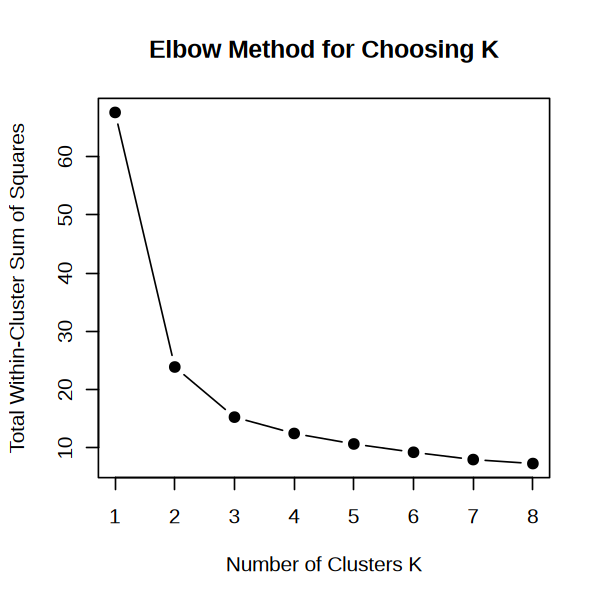

In [561]:
stp <- stringr::str_sort(grep("vCM", colnames(rpkm), value = T), numeric = T)

set.seed(921)
wss <- sapply(1:8, function(k){
  kmeans(rpkm[tforder, setdiff(stp, "vCM9")], centers = k, nstart = 10)$tot.withinss
})

options(repr.plot.width = 5, repr.plot.height = 5)
plot(1:8, wss, type = "b", pch = 19,
     xlab = "Number of Clusters K",
     ylab = "Total Within-Cluster Sum of Squares",
     main = "Elbow Method for Choosing K")

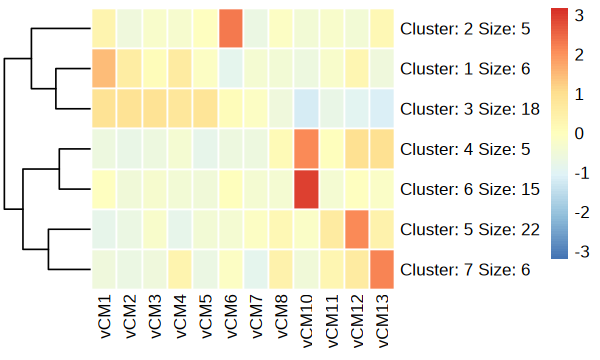

In [564]:
options(repr.plot.width = 5, repr.plot.height = 3)
set.seed(921)
f1 <- rpkm[tforder, setdiff(stp, "vCM9")] %>%
pheatmap(cluster_rows = T, cluster_cols = F, scale = "row", 
         kmeans_k = 7,
         border_color = "white", angle_col = 90)

### early: 1, 3
### med: 2, 4, 6
### late: 5, 7

In [595]:
neworder <- f1$kmeans$cluster %>% as.data.frame %>%
setNames(c("k")) %>%
mutate(k = factor(k, levels = c(1, 3, 2, 4, 6, 5, 7))) %>%
arrange(k) %>% rownames

rssdf <- rssm[neworder, stp] %>%
tibble::rownames_to_column("Var1") %>%
reshape2::melt() %>%
mutate(Var1 = factor(Var1, levels = rev(neworder))) %>%
mutate(variable = factor(variable, levels = stp))

options(repr.plot.width = 4, repr.plot.height = 15)
t1 <- rpkm[neworder, stp] %>%
reshape2::melt() %>%
mutate(Var1 = factor(Var1, levels = rev(neworder))) %>%
mutate(Var2 = factor(Var2, levels = stp)) %>%
group_by(Var1) %>% mutate(value = (value - mean(value))/sd(value)) %>% ungroup %>% 
ggplot(aes(x = Var2, y = Var1, fill = value)) + 
geom_tile() + 
geom_point(data = rssdf, aes(x = variable, y = Var1, size = value)) + 
theme_Publication() + xlab("") + ylab("") + 
scale_fill_gradientn(colours = colorRampPalette(rev(brewer.pal(n = 8, name = "RdYlBu")))(20)) + 
scale_size(range = c(0, 1.5))

ggsave(t1, filename = "plot/FIG_vCM_subtype_GRN_RSS_heatmap_kmeans.pdf", 
       dpi = 300, height = 15, width = 4)

Using Var1 as id variables

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


In [599]:
### Focus on subset of TFs
plist <- list()
for (qtf in tforder){
    qregion <- elist %>% filter(gene == qtf) %>% dplyr::select(Region) %>% unlist %>% unique
    tmp <- chmm[qregion, c('vCM_early','vCM_mid','vCM_late')] %>% #paste0("vCM", c(1:13)) 
    apply(MARGIN = 2, function(x) as.data.frame(table(x)))
    plist[[qtf]] <- do.call(rbind, tmp) %>% 
    mutate(class = gsub("^([^.]+)\\.([^.]+)$", "\\1", rownames(.))) %>%
    mutate(class = factor(class, levels = c('vCM_early','vCM_mid','vCM_late'))) %>%
    mutate(x = factor(x, levels = c("E2","E1", "E3" ,"E4", "E5"))) %>%
    ggplot(aes(x = "", y = Freq, fill = x)) +
    geom_bar(width = 1, stat = "identity", color = "white") +
    coord_polar(theta = "y") + 
    theme_void() + facet_grid(. ~ class) +
    theme(strip.text = element_blank()) + ylab(qtf) + 
    scale_fill_manual(values = cols) + NoLegend()
}

fig1 <- cowplot::plot_grid(plotlist = plist, nrow = length(plist))
ggsave(fig1, filename = "plot/FIG_vCM_subtype_GRN_target_region_chromhmm_3stage.pdf", 
       dpi = 300, height = 30, width = 4)

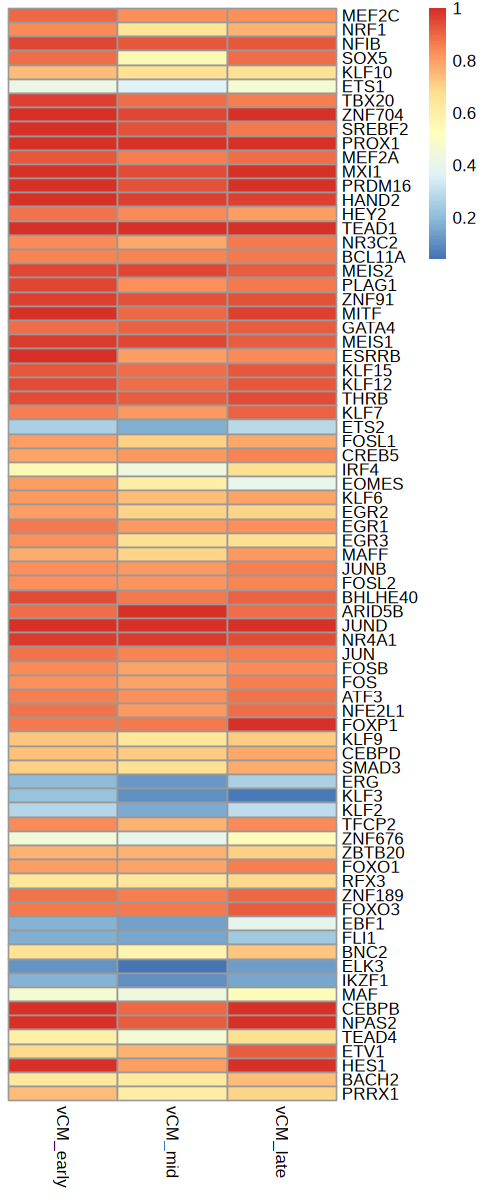

In [614]:
### Plot percent of active states shift?
dlist <- list()
for (qtf in neworder){
    qregion <- elist %>% filter(gene == qtf) %>% dplyr::select(Region) %>% unlist %>% unique
    tmp <- chmm[qregion, c('vCM_early','vCM_mid','vCM_late')] %>% #paste0("vCM", c(1:13)) 
    apply(MARGIN = 2, function(x) as.data.frame(table(x)))
    
    dlist[[qtf]] <- do.call(rbind, tmp) %>% 
    mutate(class = gsub("^([^.]+)\\.([^.]+)$", "\\1", rownames(.))) %>%
    mutate(class = factor(class, levels = c('vCM_early','vCM_mid','vCM_late'))) %>%
    mutate(x = factor(x, levels = c("E2","E1", "E3" ,"E4", "E5"))) %>%
    group_by(class) %>%
    mutate(ratio = Freq/sum(Freq)) %>%
    filter(x == "E5") %>% dplyr::select(class, ratio) %>% mutate(tf = qtf)
}
          
dlist <- do.call(rbind, dlist)
          
dmtx <- dlist %>%
reshape2::dcast(tf ~ class, value.var = "ratio") %>%
tibble::column_to_rownames("tf")
dmtx[is.na(dmtx)] <- 0

options(repr.plot.width = 4, repr.plot.height = 10)
dmtx[neworder, ] %>% ### setdiff(stp, c("vCM6", "vCM9"))
pheatmap(cluster_rows = F, cluster_cols = F)

In [15]:
head(tforder)

[1] "TBX20"  "ZNF704" "MEF2C"  "ZFY"    "SREBF2" "PROX1"

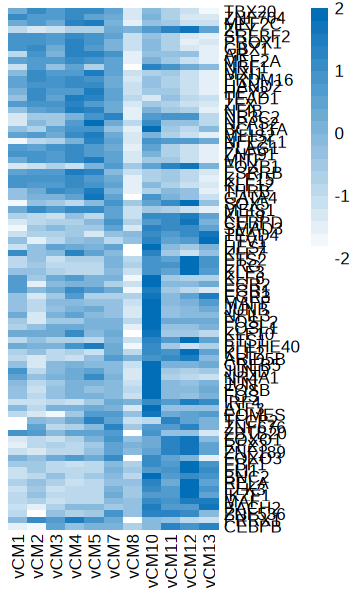

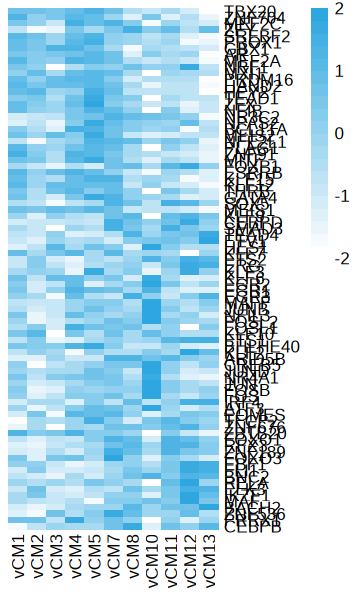

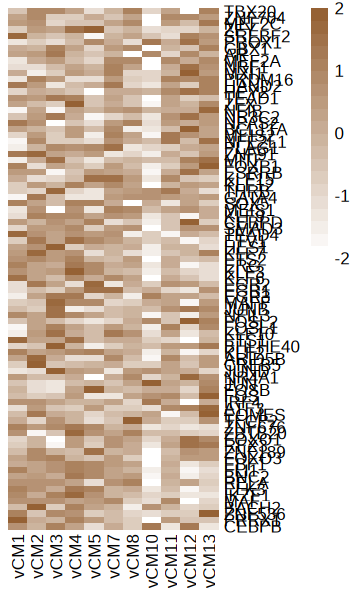

In [23]:
### Plot a subset of tf targeing bins with histone marks:
# ataccor <- accor <- mecor <- matrix(data = 0, nrow = length(tforder), ncol = length(stp), 
#                                     dimnames = list(tforder, stp))
# for (qtf in tforder){
#     ccre <- elist %>% filter(gene == qtf) %>% dplyr::select(Region) %>% unlist %>% unique
#     if (length(ccre) > 1){
#         ataccor[qtf,] <- apply(ataccpm[ccre, stp], MARGIN = 2, function(x) mean(log10(x+1), na.rm = TRUE))
#         accor[qtf,] <- apply(accpm[ccre, stp], MARGIN = 2, function(x) mean(log10(x+1), na.rm = TRUE))
#         mecor[qtf,] <- apply(mecpm[ccre, stp], MARGIN = 2, function(x) mean(log10(x+1), na.rm = TRUE))
#     }else if (length(ccre) == 1){
#         ataccor[qtf,] <- log10(ataccpm[ccre, stp]+1)
#         accor[qtf,] <- log10(accpm[ccre, stp]+1)
#         mecor[qtf,] <- log10(mecpm[ccre, stp]+1)
#     }
# }

options(repr.plot.width = 3, repr.plot.height = 5)
t1 <- ataccor[tforder, setdiff(stp, c("vCM6", "vCM9"))] %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "row", 
         border_color = NA, angle_col = 90, breaks = seq(-2, 2, 0.2),
         color = colorRampPalette(c("white", "#036EB8"))(20))

t2 <- accor[tforder, setdiff(stp, c("vCM6", "vCM9"))] %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "row", 
         border_color = NA, angle_col = 90, breaks = seq(-2, 2, 0.2),
         color = colorRampPalette(c("white", "#2EA7E0"))(20))

t3 <- mecor[tforder, setdiff(stp, c("vCM6", "vCM9"))] %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "row", 
         border_color = NA, angle_col = 90, breaks = seq(-2, 2, 0.2),
         color = colorRampPalette(c("white", "#956134"))(20))

In [24]:
ggsave(t1, filename = "plot/FIG_vCM_subtype_GRN_target_region_ATAC_cpm_EForder.pdf", 
       dpi = 300, height = 15, width = 4)
ggsave(t2, filename = "plot/FIG_vCM_subtype_GRN_target_region_H3K37ac_cpm_EForder.pdf", 
       dpi = 300, height = 15, width = 4)
ggsave(t3, filename = "plot/FIG_vCM_subtype_GRN_target_region_H3K37me3_cpm_EForder.pdf", 
       dpi = 300, height = 15, width = 4)

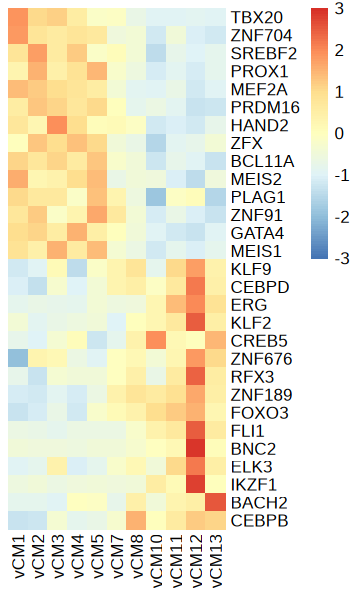

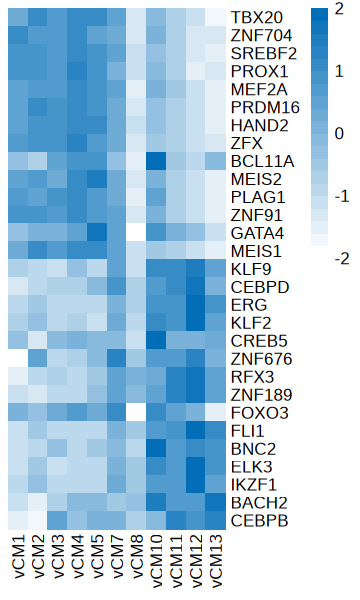

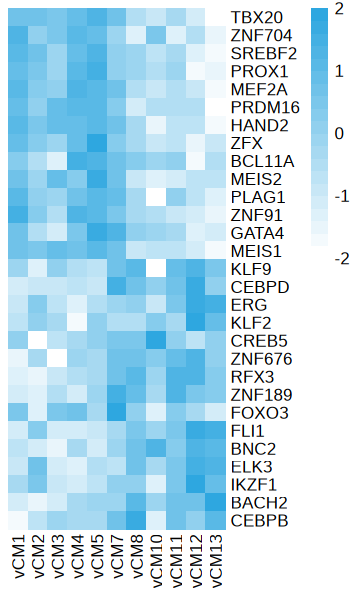

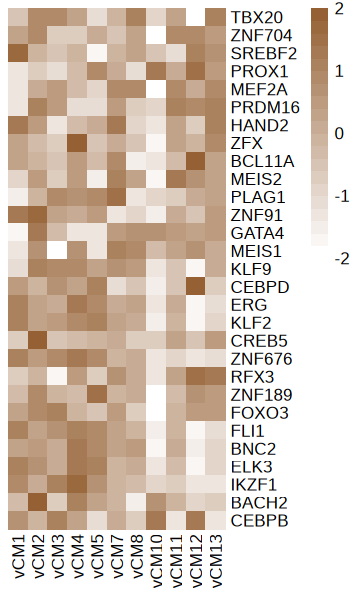

In [30]:
options(repr.plot.width = 3, repr.plot.height = 5)
t0 <- rpkm[intersect(tforder, qgene), setdiff(stp, c("vCM6", "vCM9"))] %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "row", 
         border_color = NA, angle_col = 90, breaks = seq(-3, 3, 0.06))

t1 <- ataccor[intersect(tforder, qgene), setdiff(stp, c("vCM6", "vCM9"))] %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "row", 
         border_color = NA, angle_col = 90, breaks = seq(-2, 2, 0.2),
         color = colorRampPalette(c("white", "#036EB8"))(20))

t2 <- accor[intersect(tforder, qgene), setdiff(stp, c("vCM6", "vCM9"))] %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "row", 
         border_color = NA, angle_col = 90, breaks = seq(-2, 2, 0.2),
         color = colorRampPalette(c("white", "#2EA7E0"))(20))

t3 <- mecor[intersect(tforder, qgene), setdiff(stp, c("vCM6", "vCM9"))] %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "row", 
         border_color = NA, angle_col = 90, breaks = seq(-2, 2, 0.2),
         color = colorRampPalette(c("white", "#956134"))(20))

In [31]:
ggsave(t0, filename = "plot/FIG_vCM_subtype_HF-GRN_target_region_RPKM_EForder.pdf", 
       dpi = 300, height = 15, width = 4)
ggsave(t1, filename = "plot/FIG_vCM_subtype_HF-GRN_target_region_ATAC_cpm_EForder.pdf", 
       dpi = 300, height = 15, width = 4)
ggsave(t2, filename = "plot/FIG_vCM_subtype_HF-GRN_target_region_H3K37ac_cpm_EForder.pdf", 
       dpi = 300, height = 15, width = 4)
ggsave(t3, filename = "plot/FIG_vCM_subtype_HF-GRN_target_region_H3K37me3_cpm_EForder.pdf", 
       dpi = 300, height = 15, width = 4)

In [633]:
### Fibroblast analysis
ct <- "Fibroblast"
f <- "Fibro"
elist <- read.csv(paste0("GRN/scenicplus/", f, "/edges_R2G.csv")) %>% filter(is_extended == "False") %>%
mutate(gene = stringr::str_split_fixed(Consensus_name, pattern = "_", n = 3)[,1])
rpeak <- read.table(paste0("../reference/FNIH_peaks/unified_peaks/", ct, "_UnifiedFiltVariable.bed")) %>%
mutate(range = paste0(V1, ":", V2, "-", V3))
elist <- elist %>% filter(Region %in% rpeak$range) ### retain peaks within that celltype

tforder <- read.table(paste0("GRN/subtype/", ct, "_GRN.order"))
table(tforder$V1 %in% unique(elist$gene))
table(tforder$V1 %in% bgene) ### How many on chrX/Y/M


FALSE  TRUE 
    6    91 


FALSE 
   97 

In [634]:
tforder <- setdiff(intersect(tforder$V1, unique(elist$gene)), bgene)

In [25]:
### how many of these has been associated with HF/Non HF?
qgene <- grn %>% filter(celltype == ct) %>% select(gene) %>% unlist %>% unique
length(qgene)
intersect(tforder, qgene) %>% length

[1] 32

[1] 29

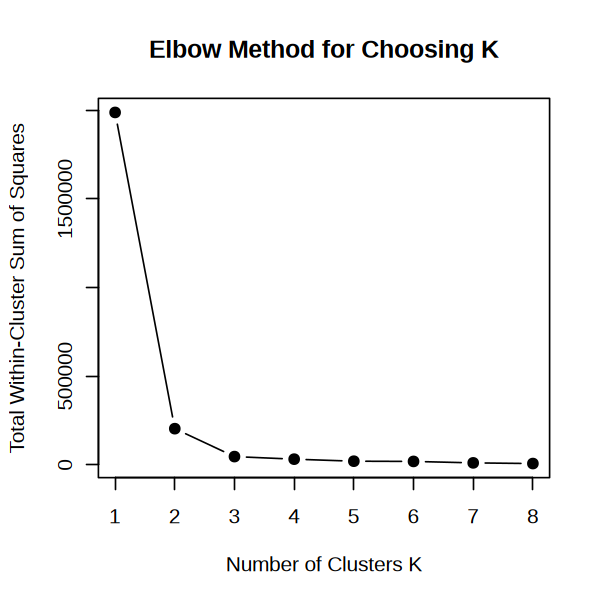

In [639]:
stp <- stringr::str_sort(grep("FB", colnames(rpkm), value = T), numeric = T)

set.seed(921)
wss <- sapply(1:8, function(k){
  kmeans(rpkm[tforder, stp], centers = k, nstart = 10)$tot.withinss
})

options(repr.plot.width = 5, repr.plot.height = 5)
plot(1:8, wss, type = "b", pch = 19,
     xlab = "Number of Clusters K",
     ylab = "Total Within-Cluster Sum of Squares",
     main = "Elbow Method for Choosing K")

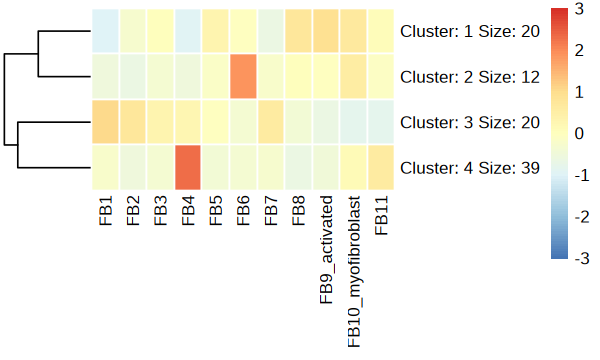

In [640]:
options(repr.plot.width = 5, repr.plot.height = 3)
set.seed(921)
f1 <- rpkm[tforder, stp] %>%
pheatmap(cluster_rows = T, cluster_cols = F, scale = "row", 
         kmeans_k = 4,
         border_color = "white", angle_col = 90)

### early: 3
### med: 4, 2
### late:1

In [646]:
neworder <- f1$kmeans$cluster %>% as.data.frame %>%
setNames(c("k")) %>%
mutate(k = factor(k, levels = c(3,4,2,1))) %>%
arrange(k) %>% rownames

# rssdf <- rpkm[neworder, stp] %>%
# tibble::rownames_to_column("Var1") %>%
# reshape2::melt() %>%
# mutate(Var1 = factor(Var1, levels = rev(neworder))) %>%
# mutate(variable = factor(variable, levels = stp))

options(repr.plot.width = 4, repr.plot.height = 15)
t1 <- rpkm[neworder, stp] %>%
reshape2::melt() %>%
mutate(Var1 = factor(Var1, levels = rev(neworder))) %>%
mutate(Var2 = factor(Var2, levels = stp)) %>%
group_by(Var1) %>% mutate(value = (value - mean(value))/sd(value)) %>% ungroup %>% 
ggplot(aes(x = Var2, y = Var1, fill = value)) + 
geom_tile() + 
# geom_point(data = rssdf, aes(x = variable, y = Var1, size = value)) + 
theme_Publication() + xlab("") + ylab("") + 
scale_fill_gradientn(colours = colorRampPalette(rev(brewer.pal(n = 8, name = "RdYlBu")))(20)) + 
scale_size(range = c(0, 1.5))

ggsave(t1, filename = paste0("plot/FIG_", ct, "_subtype_GRN_RSS_heatmap_kmeans.pdf"), 
       dpi = 300, height = 15, width = 4)

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


In [651]:
### chromatin states
# chmm <- read.table(paste0("chromhmm/cellsubtype/annotate/", ct, "_subtype_chromhmm.xls"), sep = "\t", header = T)
plist <- list()
for (qtf in neworder){
    qregion <- elist %>% filter(gene == qtf) %>% dplyr::select(Region) %>% unlist %>% unique
    tmp <- chmm[qregion, stringr::str_sort(grep("FB", colnames(rpkm), value = T), numeric = T)] %>% # c('FB_early','FB_mid','FB_late')
    apply(MARGIN = 2, function(x) as.data.frame(table(x)))
    plist[[qtf]] <- do.call(rbind, tmp) %>% 
    mutate(class = gsub("^([^.]+)\\.([^.]+)$", "\\1", rownames(.))) %>%
    mutate(class = factor(class, levels = stringr::str_sort(grep("FB", colnames(rpkm), value = T), numeric = T))) %>%
    mutate(x = factor(x, levels = c("E2","E1", "E3" ,"E4", "E5"))) %>%
    ggplot(aes(x = "", y = Freq, fill = x)) +
    geom_bar(width = 1, stat = "identity", color = "white") +
    coord_polar(theta = "y") + 
    theme_void() + facet_grid(. ~ class) +
    theme(strip.text = element_blank()) + ylab(qtf) + 
    scale_fill_manual(values = cols) + NoLegend()
}

fig1 <- cowplot::plot_grid(plotlist = plist, nrow = length(plist))
ggsave(fig1, filename = paste0("plot/FIG_", ct, "_subtype_GRN_target_region_chromhmm.pdf"), 
       dpi = 300, height = 30, width = 4)

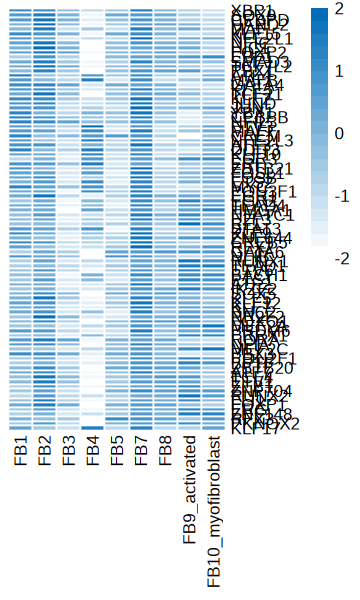

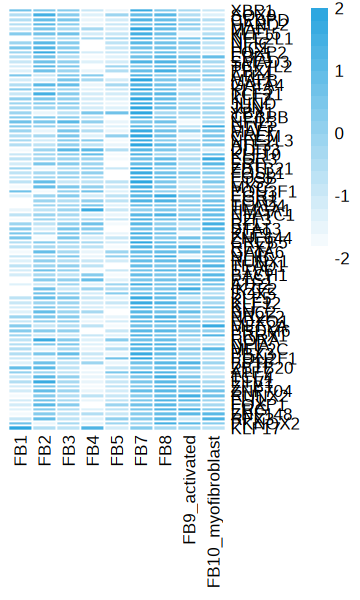

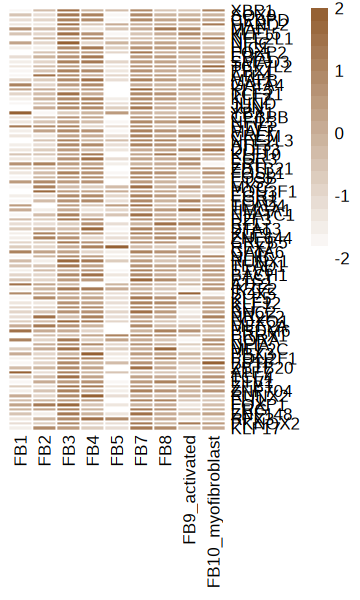

In [657]:
### Plot a subset of tf targeing bins with histone marks:
# ataccor <- accor <- mecor <- matrix(data = 0, nrow = length(neworder), ncol = length(stp), 
#                                     dimnames = list(neworder, stp))
# for (qtf in neworder){
#     ccre <- elist %>% filter(gene == qtf) %>% dplyr::select(Region) %>% unlist %>% unique
#     if (length(ccre) > 1){
#         ataccor[qtf,] <- apply(ataccpm[ccre, stp], MARGIN = 2, function(x) mean(log10(x+1), na.rm = TRUE))
#         accor[qtf,] <- apply(accpm[ccre, stp], MARGIN = 2, function(x) mean(log10(x+1), na.rm = TRUE))
#         mecor[qtf,] <- apply(mecpm[ccre, stp], MARGIN = 2, function(x) mean(log10(x+1), na.rm = TRUE))
#     }else if (length(ccre) == 1){
#         ataccor[qtf,] <- log10(ataccpm[ccre, stp]+1)
#         accor[qtf,] <- log10(accpm[ccre, stp]+1)
#         mecor[qtf,] <- log10(mecpm[ccre, stp]+1)
#     }
# }

options(repr.plot.width = 3, repr.plot.height = 5)
t1 <- ataccor[neworder, setdiff(stp, c("FB6", "FB11"))] %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "row", 
         border_color = "white", angle_col = 90, breaks = seq(-2, 2, 0.2),
         color = colorRampPalette(c("white", "#036EB8"))(20))

t2 <- accor[neworder, setdiff(stp, c("FB6", "FB11"))] %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "row", 
         border_color = "white", angle_col = 90, breaks = seq(-2, 2, 0.2),
         color = colorRampPalette(c("white", "#2EA7E0"))(20))

t3 <- mecor[neworder, setdiff(stp, c("FB6", "FB11"))] %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "row", 
         border_color = "white", angle_col = 90, breaks = seq(-2, 2, 0.2),
         color = colorRampPalette(c("white", "#956134"))(20))

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


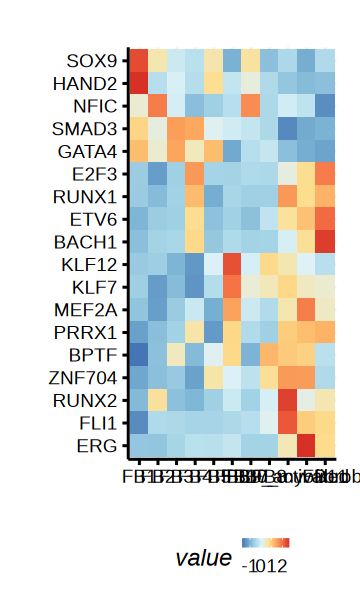

In [662]:
rpkm[intersect(neworder, qgene), stp] %>%
reshape2::melt() %>%
mutate(Var1 = factor(Var1, levels = rev(intersect(neworder, qgene)))) %>%
mutate(Var2 = factor(Var2, levels = stp)) %>%
group_by(Var1) %>% mutate(value = (value - mean(value))/sd(value)) %>% ungroup %>% 
ggplot(aes(x = Var2, y = Var1, fill = value)) + 
geom_tile() + 
theme_Publication() + xlab("") + ylab("") + 
scale_fill_gradientn(colours = colorRampPalette(rev(brewer.pal(n = 8, name = "RdYlBu")))(20)) + 
scale_size(range = c(0, 1.5))

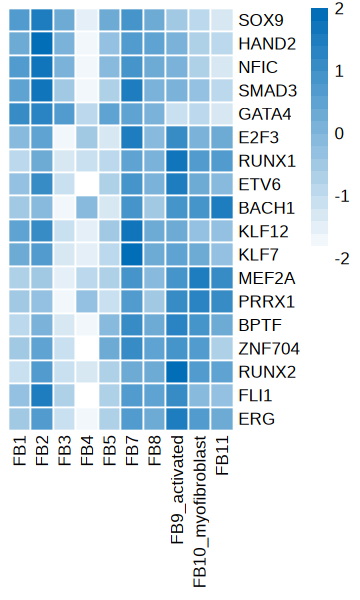

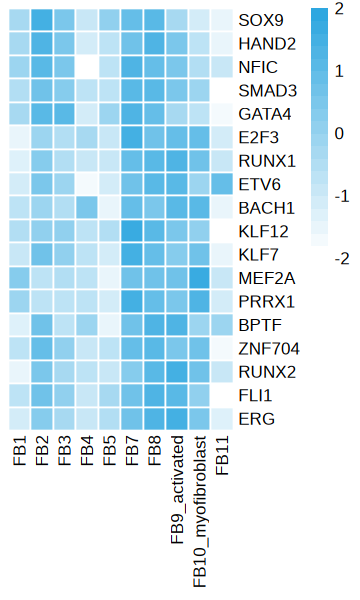

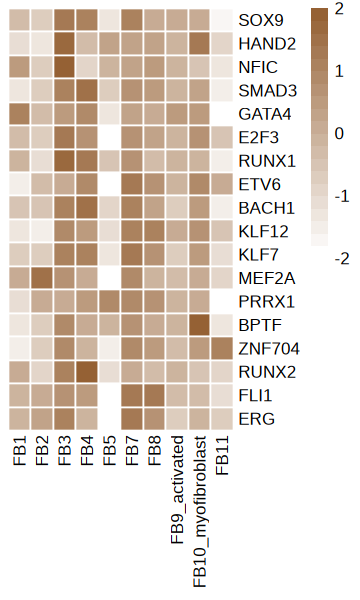

In [665]:
options(repr.plot.width = 3, repr.plot.height = 5)
t1 <- ataccor[intersect(neworder, qgene), setdiff(stp, c("FB6"))] %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "row", 
         border_color = "white", angle_col = 90, breaks = seq(-2, 2, 0.2),
         color = colorRampPalette(c("white", "#036EB8"))(20))

t2 <- accor[intersect(neworder, qgene), setdiff(stp, c("FB6"))] %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "row", 
         border_color = "white", angle_col = 90, breaks = seq(-2, 2, 0.2),
         color = colorRampPalette(c("white", "#2EA7E0"))(20))

t3 <- mecor[intersect(neworder, qgene), setdiff(stp, c("FB6"))] %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "row", 
         border_color = "white", angle_col = 90, breaks = seq(-2, 2, 0.2),
         color = colorRampPalette(c("white", "#956134"))(20))